<a href="https://colab.research.google.com/github/HaiyanKong/NMA2021Computational-Neuroscience/blob/main/final%20project/NeuromatchAcademy2021_ComputationalNeuroscience_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import json
import urllib.request

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import matplotlib.pyplot as plt

In [ ]:
urllib.request.urlretrieve('https://data.caltech.edu/tindfiles/serve/a86f4297-a087-4f40-9ed4-765779105c2c/', 'task1.zip')
urllib.request.urlretrieve('https://data.caltech.edu/tindfiles/serve/ca84a583-ea06-440a-995c-c184bcb0291c/', 'calms21_convert_to_npy.py')
!unzip task1.zip

Archive:  task1.zip
   creating: task1_classic_classification/
  inflating: task1_classic_classification/taskprog_features_task1_train.json  
  inflating: task1_classic_classification/calms21_task1_test.json  
  inflating: task1_classic_classification/taskprog_features_task1_test.json  
  inflating: task1_classic_classification/calms21_task1_train.json  


In [ ]:
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.' --parse_treba

Saving ./calms21_task1_test
tcmalloc: large alloc 1224941568 bytes == 0x563398aca000 @  0x7eff5a3921e7 0x563390168a18 0x563390133987 0x5633902b2335 0x56339024ca48 0x563390137252 0x56339021596e 0x56339024c9c2 0x563390137252 0x56339013a496 0x5633902b59c3 0x563390136ea9 0x563390228c0d 0x5633901ab0d8 0x5633901a6235 0x56339013873a 0x5633901aaf40 0x5633901a5c35 0x56339013873a 0x5633901a6b0e 0x56339013865a 0x5633901a6b0e 0x5633901a5c35 0x5633901a5933 0x56339026f402 0x56339026f77d 0x56339026f626 0x563390247313 0x563390246fbc 0x7eff5917cbf7 0x563390246e9a
tcmalloc: large alloc 1224941568 bytes == 0x5633e1afc000 @  0x7eff5a3921e7 0x563390168a18 0x56339017df6c 0x56339020bb93 0x563390136ea9 0x563390136da0 0x5633901ab2f9 0x5633901a5c35 0x563390138dd1 0x563390138280 0x56339013a208 0x563390217141 0x5633902b59f1 0x563390136ea9 0x563390228c0d 0x5633901ab0d8 0x5633901a6235 0x56339013873a 0x5633901aaf40 0x5633901a5c35 0x56339013873a 0x5633901a6b0e 0x56339013865a 0x5633901a6b0e 0x5633901a5c35 0x5633901a59

In [ ]:
import numpy as np

def load_task1_data(data_path):
    """ 
    Load data for task 1:
        The vocaubulary tells you how to map behavior names to class ids;
        it is the same for all sequences in this dataset.
    """
    data_dict = np.load(data_path, allow_pickle=True).item()
    dataset = data_dict['annotator-id_0']
    # Get any sequence key.
    sequence_id = list(data_dict['annotator-id_0'].keys())[0]
    vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
    return dataset, vocabulary

In [ ]:
training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

In [ ]:
#我把这里改了，方便后面转换数据集0-70
def Data(Dataname, num):
  sequence_names = list(Dataname.keys())
  sample_sequence_key = sequence_names[num]
  single_sequence = Dataname[sample_sequence_key]

  keypoint_sequence = single_sequence['keypoints']
  annotation_sequence = single_sequence['annotations']
  F_num = annotation_sequence.shape[0]
  return sample_sequence_key,keypoint_sequence,annotation_sequence,F_num

In [ ]:
def mouse_distance(sample_sequence_key, keypoint_sequence, start_frame = 0, stop_frame = 100):
    distance = np.sqrt(np.sum((keypoint_sequence[start_frame:stop_frame,0,:,:] - keypoint_sequence[start_frame:stop_frame,1,:,:])**2, axis = 1))
    return {sample_sequence_key:distance}

In [ ]:
def mouse_angle(sample_sequence_key, keypoint_sequence, start_frame = 0, stop_frame = 100):
    ### 
    # units are degrees
    # h1 represents head vector for the first mouse, l1 represents body vector for the second mouse
    # (h1,l1) represents the angle between the two vectors
    # the order of output is (l1,h1),(l2,h2),(l1,l2),(h1,h2),(l1,h2),(l2,h1)
    # [start frame,stop frame-1]
    ###
    
    def angle(v1, v2):
        r = np.sum(v1*v2,axis = 1)/(np.sqrt(np.sum(v1**2,axis = 1))*np.sqrt(np.sum(v2**2,axis = 1)))
        r = np.clip(r,-1,1)
        theta = np.arccos(r)/np.pi*180
        return theta
    
    h1 = keypoint_sequence[start_frame:stop_frame,0,:,0] - keypoint_sequence[start_frame:stop_frame,0,:,3]
    l1 = keypoint_sequence[start_frame:stop_frame,0,:,3] - keypoint_sequence[start_frame:stop_frame,0,:,6]
    h2 = keypoint_sequence[start_frame:stop_frame,1,:,0] - keypoint_sequence[start_frame:stop_frame,1,:,3]
    l2 = keypoint_sequence[start_frame:stop_frame,1,:,3] - keypoint_sequence[start_frame:stop_frame,1,:,6]
    theta_sequence = np.transpose(np.array([angle(l1,h1),angle(l2,h2),angle(l1,l2),angle(h1,h2),angle(l1,h2),angle(l2,h1)]))
    return {sample_sequence_key:theta_sequence}
    

In [ ]:
def mouse_speed(sample_sequence_key, keypoint_sequence, start_frame = 0, stop_frame = 100):
    
    speed_mag_sequence = np.empty((0,2,7), int)
    speed_dir_sequence = np.empty((0,2,7), int)
    for i in range(start_frame,stop_frame):
        speed_vec = keypoint_sequence[i+1,:,:,:]-keypoint_sequence[i,:,:,:]
        speed_mag = np.sqrt(np.sum(speed_vec**2,axis = 1)) + 1e-50
        speed_dir = np.arccos(speed_vec[:,0,:]/speed_mag)/np.pi*180
        speed_mag_sequence = np.append(speed_mag_sequence, [speed_mag], axis = 0)
        speed_dir_sequence = np.append(speed_dir_sequence, [speed_dir], axis = 0)
    return {sample_sequence_key:{'speed_mag':speed_mag_sequence,'speed_dir':speed_dir_sequence}}


In [ ]:
def mouse_input(sample_sequence_key, keypoint_sequence, start_frame = 0, stop_frame = 100):
    mouse_dis = mouse_distance(sample_sequence_key, keypoint_sequence, start_frame, stop_frame)[sample_sequence_key]
    mouse_ang = mouse_angle(sample_sequence_key, keypoint_sequence, start_frame, stop_frame)[sample_sequence_key]
    mouse_sp_mg = mouse_speed(sample_sequence_key, keypoint_sequence, start_frame, stop_frame)[sample_sequence_key]['speed_mag']
    mouse_sp_dir = mouse_speed(sample_sequence_key, keypoint_sequence, start_frame, stop_frame)[sample_sequence_key]['speed_dir']
    mouse_sp_mg = np.reshape(mouse_sp_mg,(stop_frame-start_frame,14))
    mouse_sp_dir = np.reshape(mouse_sp_dir,(stop_frame-start_frame,14))
    return np.concatenate((mouse_dis,mouse_ang,mouse_sp_mg,mouse_sp_dir), axis = 1)

In [ ]:
#初始化参数
input_size = 41
batch_size= 1
seq_len = 100   #nframes
hidden_size1 = 20
hidden_size2 = 10
output_size = 4




#建立模型
class Model(torch.nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, batch_size, output_size):
    super(Model, self).__init__()
    self.input_size = input_size
    self.hidden_size1 = hidden_size1
    self.hidden_size2 = hidden_size2
    self.batch_size = batch_size
    self.rnncell1 = torch.nn.RNNCell(input_size = self.input_size, hidden_size = self.hidden_size1)
    self.rnncell2 = torch.nn.RNNCell(input_size = self.hidden_size1, hidden_size = self.hidden_size2)
    self.linear = nn.Linear(hidden_size2, output_size)
  def forward(self, input, hidden1, hidden2):
    hidden1 = self.rnncell1(input, hidden1)
    hidden2 = self.rnncell2(hidden1, hidden2)
    output = self.linear(hidden2)
    return hidden1, hidden2, output

  def init_hidden(self):
    return torch.zeros(self.batch_size, self.hidden_size1),torch.zeros(self.batch_size, self.hidden_size2)

net = Model(input_size, hidden_size1, hidden_size2, batch_size, output_size)


#
optimizer = torch.optim.SGD(net.parameters(), lr=0.0002, momentum=0.00006)  #0.000002,0.0000006
CEloss = torch.nn.CrossEntropyLoss()     #交叉熵损失函数，包含了独热编码过程



#训练优化
k_loss = np.zeros(2)
for n in range(0,2):
  sample_sequence_key,keypoint_sequence,annotation_sequence,F_num = Data(training_data, n) 
  my_train = mouse_input(sample_sequence_key, keypoint_sequence, start_frame = 0, stop_frame = F_num-1)
  my_label = annotation_sequence
  Epoch = F_num-seq_len-1

  y = np.zeros(Epoch)
  for epoch in range(Epoch):
    loss = 0
    optimizer.zero_grad()
    hidden1, hidden2 = net.init_hidden()
    for i in range(seq_len):
      input = torch.Tensor(my_train[epoch+i,:]).view(1,-1)
      hidden1,hidden2,output = net(input, hidden1, hidden2)
    label = torch.LongTensor([my_label[epoch+seq_len]]).view(1)
    output = output.view(-1,4)
    loss = CEloss(output, label)
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
      print('times:%d Epoch[%d/%d] loss=%.3f' %(n+1,epoch,Epoch,loss.item()))
    y[epoch] = loss.item()
  
  k_loss[n] = np.mean(y)
  print('times:%d >>>>>>>>>> loss=%.3f' %(n+1,k_loss[n]))


times:1 Epoch[0/21263] loss=1.494
times:1 Epoch[100/21263] loss=1.310
times:1 Epoch[200/21263] loss=1.211
times:1 Epoch[300/21263] loss=0.966
times:1 Epoch[400/21263] loss=0.950
times:1 Epoch[500/21263] loss=0.819
times:1 Epoch[600/21263] loss=0.739
times:1 Epoch[700/21263] loss=0.809
times:1 Epoch[800/21263] loss=1.460
times:1 Epoch[900/21263] loss=0.779
times:1 Epoch[1000/21263] loss=1.307
times:1 Epoch[1100/21263] loss=0.797
times:1 Epoch[1200/21263] loss=1.274
times:1 Epoch[1300/21263] loss=0.643
times:1 Epoch[1400/21263] loss=0.719
times:1 Epoch[1500/21263] loss=0.801
times:1 Epoch[1600/21263] loss=1.342
times:1 Epoch[1700/21263] loss=0.759
times:1 Epoch[1800/21263] loss=1.380
times:1 Epoch[1900/21263] loss=1.276
times:1 Epoch[2000/21263] loss=2.348
times:1 Epoch[2100/21263] loss=1.066
times:1 Epoch[2200/21263] loss=0.821
times:1 Epoch[2300/21263] loss=0.852
times:1 Epoch[2400/21263] loss=1.173
times:1 Epoch[2500/21263] loss=0.793
times:1 Epoch[2600/21263] loss=1.000
times:1 Epoch

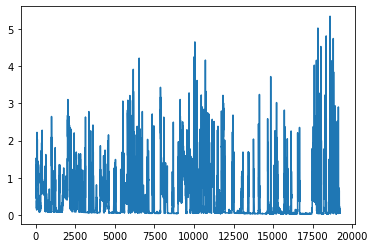

In [ ]:
x = np.arange(Epoch)
plt.plot(x,y)

In [ ]:
correct = 0
all_test_num = 0
for n in range(0,1):
  sample_sequence_key,keypoint_sequence,annotation_sequence,F_num = Data(test_data, n) 
  my_test = mouse_input(sample_sequence_key, keypoint_sequence, start_frame = 0, stop_frame = F_num-1)
  my_label = annotation_sequence
  Epoch = F_num-seq_len-1
  all_test_num = all_test_num + Epoch

  y = np.zeros(Epoch)
  for epoch in range(Epoch):
    hidden1, hidden2 = net.init_hidden()
    for i in range(seq_len):
      input = torch.Tensor(my_test[epoch+i,:]).view(1,-1)
      hidden1,hidden2,output = net(input, hidden1, hidden2)
    label = torch.LongTensor([my_label[epoch+seq_len]]).view(1)
    output = output.view(-1,4)
    _,index = output[0,:].max(0)
    print("%d  %d"%(index,label))
    if index==label:
      correct = correct+1
print("准确率:%.0f%%"%(correct/all_test_num*100))

流式输出内容被截断，只能显示最后 5000 行内容。
3  2
3  2
3  2
1  2
1  2
1  2
1  2
3  2
1  2
1  2
2  2
1  2
2  2
1  2
1  2
0  2
2  2
2  2
2  2
2  2
2  2
2  2
2  2
2  2
2  2
2  2
2  2
2  2
3  2
3  2
3  1
3  1
3  1
0  1
1  1
1  1
3  1
3  1
3  1
3  1
3  1
3  1
3  1
3  1
3  1
3  1
1  1
1  1
0  1
1  1
1  1
1  1
1  1
1  1
1  3
1  3
0  3
1  3
1  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  3
3  